# Ultimate Data Science Challenge

## Part 1 - Exploratory Data Analysis
Aggregate the login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles.

Firstly, import relevant libraries and read data into pandas dataframe.

In [0]:
import numpy as np
import pandas as pd
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from datetime import datetime
%matplotlib inline

In [0]:
logins = pd.read_json("logins.json")
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Next, check for nulls and extract useful information from the timestamp.

In [0]:
logins.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


There are no null values (there's only one column of data) and the column is already in datetime format.

In [0]:
logins['year'] = logins['login_time'].dt.year
logins['month'] = logins['login_time'].dt.month
logins['day'] = logins['login_time'].dt.day
logins['day_of_week'] = logins['login_time'].dt.day_name()
logins['hour'] = logins['login_time'].dt.hour
logins['minute'] = logins['login_time'].dt.minute

In [0]:
logins.head()

,login_time,year,month,day,day_of_week,hour,minute
0,1970-01-01 20:13:18,1970,1,1,Thursday,20,13
1,1970-01-01 20:16:10,1970,1,1,Thursday,20,16
2,1970-01-01 20:16:37,1970,1,1,Thursday,20,16
3,1970-01-01 20:16:36,1970,1,1,Thursday,20,16
4,1970-01-01 20:26:21,1970,1,1,Thursday,20,26


Add a "count" column to assist with counting values over different time periods.

In [0]:
logins['count'] = 1

In [0]:
logins.describe()

,year,month,day,hour,minute,count
count,93142.0,93142.000000,93142.000000,93142.000000,93142.000000,93142.0
mean,1970.0,2.424062,14.667830,11.635363,29.801711,1.0
std,0.0,0.995154,8.596967,7.816792,17.245034,0.0
min,1970.0,1.000000,1.000000,0.000000,0.000000,1.0
25%,1970.0,2.000000,7.000000,4.000000,15.000000,1.0
50%,1970.0,3.000000,14.000000,12.000000,30.000000,1.0
75%,1970.0,3.000000,22.000000,19.000000,45.000000,1.0
max,1970.0,4.000000,31.000000,23.000000,59.000000,1.0


Visualize the data over different time periods.

In [0]:
whole = logins.groupby([pd.Grouper(key='login_time', freq='1W')])['count'].sum().reset_index()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


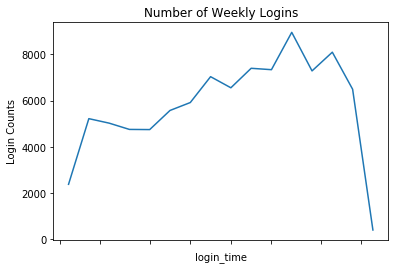

In [0]:
chart = sns.lineplot(x='login_time',y='count', data=whole)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.ylabel('Login Counts')
plt.title('Number of Weekly Logins');

The data was collected in 1970 only, between January and April, thoughout the day. Let's investigate logins across the months

In [0]:
lgroup = logins.groupby(['month'])['count'].sum().reset_index()
lgroup.head()

,month,count
0,1,21239
1,2,24673
2,3,33723
3,4,13507


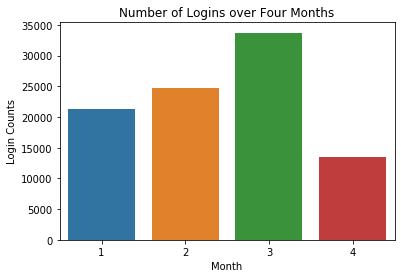

In [0]:
sns.barplot(x='month', y='count', data=lgroup)
plt.ylabel('Login Counts')
plt.xlabel('Month')
plt.title('Number of Logins over Four Months');

There was a spike in logins in the month of March. Let's take a look at each month individually

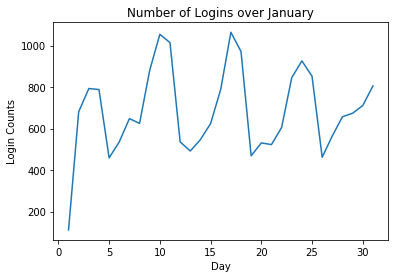

In [0]:
jan = logins.loc[logins['month'] == 1].groupby(['day'])['count'].sum().reset_index()
sns.lineplot(x='day', y='count', data=jan)
plt.ylabel('Login Counts')
plt.xlabel('Day')
plt.title('Number of Logins over January');

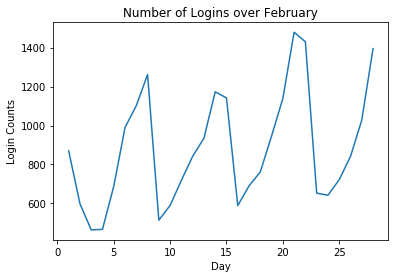

In [0]:
feb = logins.loc[logins['month'] == 2].groupby(['day'])['count'].sum().reset_index()
sns.lineplot(x='day', y='count', data=feb)
plt.ylabel('Login Counts')
plt.xlabel('Day')
plt.title('Number of Logins over February');

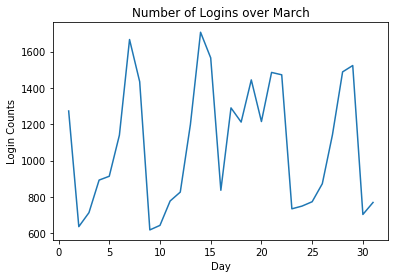

In [0]:
mar = logins.loc[logins['month'] == 3].groupby(['day'])['count'].sum().reset_index()
sns.lineplot(x='day', y='count', data=mar)
plt.ylabel('Login Counts')
plt.xlabel('Day')
plt.title('Number of Logins over March');

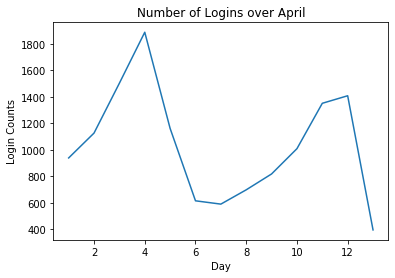

In [0]:
apr = logins.loc[logins['month'] == 4].groupby(['day'])['count'].sum().reset_index()
sns.lineplot(x='day', y='count', data=apr)
plt.ylabel('Login Counts')
plt.xlabel('Day')
plt.title('Number of Logins over April');

There are several spikes in logins over each month. Let's narrow in further with a look at activity on each day of the week.

In [0]:
days_wk = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week = logins.groupby(['day_of_week'])['count'].sum().reindex(days_wk).reset_index()
week.head(7)

,day_of_week,count
0,Monday,8823
1,Tuesday,9268
2,Wednesday,10339
3,Thursday,11960
4,Friday,15208
5,Saturday,19377
6,Sunday,18167


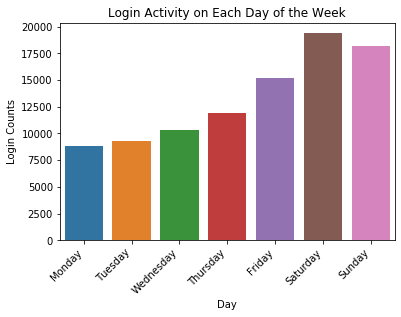

In [0]:
dow = sns.barplot(x='day_of_week', y='count', data=week)
dow.set_xticklabels(dow.get_xticklabels(), rotation=45, ha="right")
plt.ylabel('Login Counts')
plt.xlabel('Day')
plt.title('Login Activity on Each Day of the Week');
plt.show()

This plot above shows that the weekend is where most activity takes place. Now let's a take look at activity during the day to see at what time most logins take place.

In [0]:
hr = logins.groupby(['hour'])['count'].sum().reset_index()
hr.head()

,hour,count
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


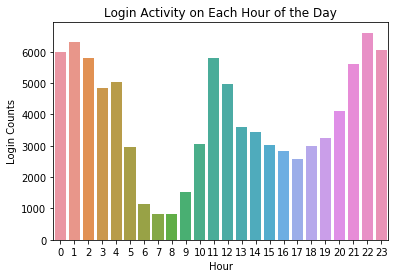

In [0]:
sns.barplot(x='hour', y='count', data=hr)
plt.ylabel('Login Counts')
plt.xlabel('Hour')
plt.title('Login Activity on Each Hour of the Day');
plt.show()

It appears most activity takes place during non-working hours and around the middle of the day (lunch time perhaps). Let's take a look at activity on a weekday vs weekend.

In [0]:
wkdy = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
wknd = ['Saturday', 'Sunday']

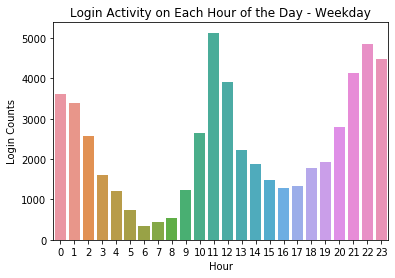

In [0]:
hr1 = logins.loc[logins['day_of_week'].isin(wkdy)].groupby(['hour'])['count'].sum().reset_index()
sns.barplot(x='hour', y='count', data=hr1)
plt.ylabel('Login Counts')
plt.xlabel('Hour')
plt.title('Login Activity on Each Hour of the Day - Weekday');
plt.show()

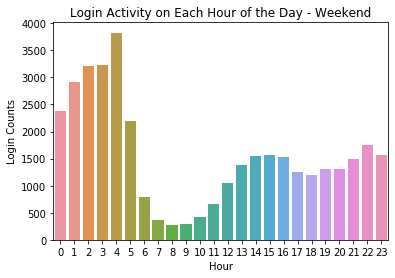

In [0]:
hr2 = logins.loc[logins['day_of_week'].isin(wknd)].groupby(['hour'])['count'].sum().reset_index()
sns.barplot(x='hour', y='count', data=hr2)
plt.ylabel('Login Counts')
plt.xlabel('Hour')
plt.title('Login Activity on Each Hour of the Day - Weekend');
plt.show()

From the 2 plots above, it appears login activity spikes at non-working hours during the week, while on weekends there are usage spikes at the early hours of the morning.

## Part 2 - Experiment and Metrics Design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

**Solution**

The metric I would choose is the percentage of trips in each city versus trips serving both cities (starting the trip in one city and ending it across the toll bridge to the other city). This experiment would be carried out before and after toll costs are reimbursed.

This would indicate whether there is an increase, decrease or no change in drivers serving both cities.
Data needed:
*   Driver ID
*   Trip start and end coordinates
*   Trip start and end timestamp
*   Toll paid
*   City affiliation - Ultimate Gotham or Ultimate Metropolis
*   Fare cost
*   Number of passengers

This data can be gleaned from the application used to hail the drivers.


## Part 3 - Predictive Modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [0]:
with open('ultimate_data_challenge.json') as f:
   data = json.load(f)
ultimate = pd.DataFrame(data)
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


#### Data Exploration and Cleaning

For this step, we'll look for data types, convert dates columns to date format and fill in missing values.

In [0]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [0]:
#convert date columns to date format
ultimate['signup_date'] = pd.to_datetime(ultimate['signup_date'])
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])

In [0]:
ultimate.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

There are some null values to be filled. For the average rating columns, the null values will be filled with the mean value of the respective columns.

In [0]:
ultimate['avg_rating_of_driver'].fillna((ultimate['avg_rating_of_driver'].mean()), inplace=True)
ultimate['avg_rating_by_driver'].fillna((ultimate['avg_rating_by_driver'].mean()), inplace=True)

In [0]:
ultimate.isnull().sum()

city                        0
trips_in_first_30_days      0
signup_date                 0
avg_rating_of_driver        0
avg_surge                   0
last_trip_date              0
phone                     396
surge_pct                   0
ultimate_black_user         0
weekday_pct                 0
avg_dist                    0
avg_rating_by_driver        0
dtype: int64

There are still some null values in the phone column - 396 or 0.8% of the dataset. The null values can be replaced by either one of the phone types or deleted. To fill in the null values, the two phone types ('Iphone' or 'Android Phone') will be randomly assigned. This should remove the last of the missing values in the dataframe.

In [0]:
ultimate['phone'].fillna(random.choice(['iPhone','Android Phone']), inplace =True)

In [0]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


#### Data Visualization
Now that our data has been cleaned, let's look at some visualizations of the dataset.

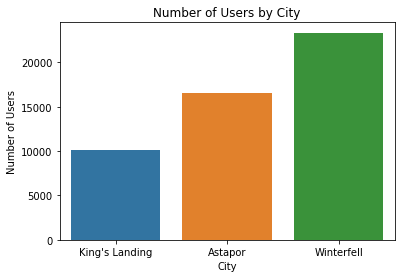

In [0]:
sns.countplot(x='city', data=ultimate)
plt.ylabel('Number of Users')
plt.xlabel('City')
plt.title('Number of Users by City');

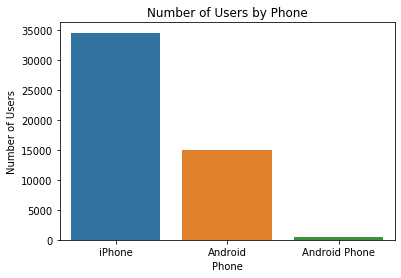

In [0]:
sns.countplot(x='phone', data=ultimate)
plt.ylabel('Number of Users')
plt.xlabel('Phone')
plt.title('Number of Users by Phone');

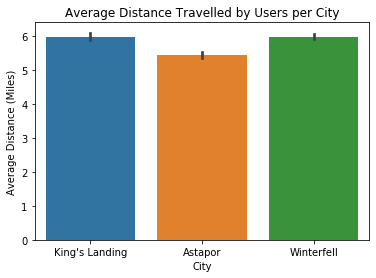

In [0]:
sns.barplot(x='city', y='avg_dist', data=ultimate)
plt.ylabel('Average Distance (Miles)')
plt.xlabel('City')
plt.title('Average Distance Travelled by Users per City');

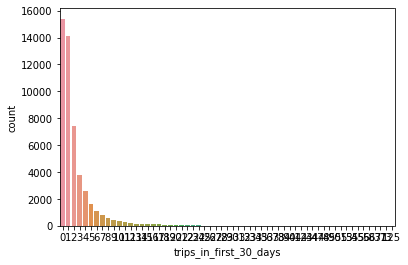

In [0]:
sns.countplot(x='trips_in_first_30_days', data=ultimate)

#### Data Modeling
A user is designated as 'active' if they took a trip in the last 30 days. To determine active users, the 30-day time period for the data set needs to be determined (the last date in the dataset under the last_trip_date column is extracted and 30 days are counted from that point).

From there, a count is taken of all the users that had a trip in that time period. The fraction of users that are considered active will be this count divided by the total number of users in the dataset (50,000).

In [0]:
#The trips made in the last 30 days are to be determined. First let's get the last date of the data
ultimate[['last_trip_date']].max()

last_trip_date   2014-07-01
dtype: datetime64[ns]

In [0]:
#find the no. of rows with trips in the last 30 days
retained = len(ultimate[(ultimate['last_trip_date'] >= '2014-05-31')])

In [0]:
#percentage of retained users
print ("{0:.2f}".format((retained/len(ultimate))*100),"%")

38.45 %


Let's add a column to the dataframe to identify active users - users that took a trip in the last month as recorded in the data set (i.e. the month of June and first day of July).

In [0]:
ultimate['active'] = np.where(ultimate['last_trip_date']>= '2014-06-01', 1, 0)

In [0]:
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


To prepare our data for model training, let's encode some of the categorical columns like "phone", "city" and "ultimate_black_user".

In [0]:
le = LabelEncoder()

In [0]:
ultimate['city']=le.fit_transform(ultimate['city'])
ultimate['phone']=le.fit_transform(ultimate['phone'])
ultimate['ultimate_black_user']=le.fit_transform(ultimate['ultimate_black_user'])
ultimate = pd.get_dummies(ultimate, columns=['city'])

In [0]:
ultimate.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_0,city_1,city_2
0,4,2014-01-25,4.7,1.10,2014-06-17,2,15.4,1,46.2,3.67,5.0,1,0,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0,0.0,0,50.0,8.26,5.0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,2,0.0,0,100.0,0.77,5.0,0,1,0,0
3,9,2014-01-10,4.6,1.14,2014-06-29,2,20.0,1,80.0,2.36,4.9,1,0,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,0,11.8,0,82.4,3.13,4.9,0,0,0,1


Now that our data is free of categorical values, let's assign our features and label columns. For our features dataframe X, the date columns will be dropped along with the target column, 'active', and one of the one-hot encoded columns for 'city'. Our label column, y, is just the 'active' column.

Then, data is split into training and test sets and fit to our models. Two classification models, Random Forest Classifier and XGBoost will be used to compare results.

In [0]:
X = ultimate.drop(['signup_date', 'last_trip_date', 'active', 'city_2'], axis=1)
y = ultimate['active']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### XGBoost

In [0]:
model = XGBClassifier(n_estimators=600)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
predictions = model.predict(X_test)

In [0]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84     10305
           1       0.74      0.67      0.71      6195

    accuracy                           0.79     16500
   macro avg       0.78      0.77      0.77     16500
weighted avg       0.79      0.79      0.79     16500



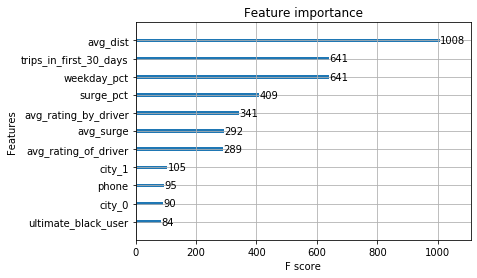

In [0]:
plot_importance(model)
plt.show()

Random Forest Classifier

In [0]:
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [0]:
param_grid = { 
    'n_estimators': [150, 175, 200 , 225],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini','entropy']
}
rfcv = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
rfcv.fit(X_train, y_train)
print (rfcv.best_params_)

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 175}


In [0]:
y_pred = rfcv.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[8338 1967]
 [2101 4094]]


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80     10305
           1       0.68      0.66      0.67      6195

    accuracy                           0.75     16500
   macro avg       0.74      0.73      0.74     16500
weighted avg       0.75      0.75      0.75     16500



Both  models were chosen because they are very popular among classification models and give relatively high accuracy. A grid search was completed for the RF model to determine the best parameters to give the highest accuracy. For the XGB model, different numbers of estimators were tried with very little variance in the resultant accuracy. Further hyperparameter tuning for this model can be performed to obtained the best model for the data seet.

From the code above, it is observed that the XGBoost model has a slight edge over the Random Forest model with an accuracy score of 79% vs 75%. 

Feature importances were extracted from the XGBoost model to determine which factors might influence the model performance. From the horizontal bar plot above, the three highest scoring features were avg_dist, trips_in_first_30_days and weekday_pct. Ultimate can improve its long-term rider retention by incentivzing users when they use the service in the first 30 days, on weekdays or use the service more frequently or for longer distances.